In [1]:
using Revise

In [2]:
using Model
using LogExpFunctions: softmax
using CairoMakie

In [3]:
decisions = Model.loaddata("../../data/processed/json_augmented");

In [4]:
problem = BPatGModel(decisions);

In [5]:
@time post = Model.sample(problem, 1500, 2; backend=:ReverseDiff)

1228.715107 seconds (54.15 M allocations: 15.027 GiB, 0.29% gc time, 2.19% compilation time)


DynamicHMCPosterior with 3000 samples and parameters (:α, :zs, :σs, :zy, :σy, :zj, :σj, :zt, :σt)

In [40]:
# using InferenceObjects
# idata = convert_to_inference_data(problem, post)

In [9]:
Model.checkconvergence(post)[3]

Hamiltonian Monte Carlo sample of length 3000
  acceptance rate mean: 0.9, 5/25/50/75/95%: 0.67 0.85 0.94 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 100%

# Judge results

In [10]:
function topkgroups(groups, k=10)
    js = reduce(vcat, groups)
    df = DataFrame(groups=js)
    df = combine(groupby(df, :groups), nrow => :count)
    df = sort!(df, :count; rev=true)
    first(df.groups, k)
end

topkgroups (generic function with 2 methods)

In [11]:
function marginaleffects(post, element; group=:judges)
    params = if group == :judges
        (zs=:zj, σs=:σj)
    elseif group == :cpc
        (zs=:zt, σs=:σt)
    else
        throw(ArgumentError("Unknown group."))
    end

    map(post) do s
        zs = getproperty(s, params.zs)
        ze = getindex(zs, element)
        σs = getproperty(s, params.σs)
        αs = s.α
        softmax(vcat(0, αs .+ ze .* σs))
    end
end

marginaleffects (generic function with 1 method)

In [38]:
function plot_marginal_probabilities!(ax, probs)
    for (i, vals) in enumerate(eachcol(hcat(probs...)'))
        m, sd = mean(vals), std(vals)
        errorbars!(ax, [i], [m], [sd]; cycle=:color)
        scatter!(ax, i, m)
    end    
end
function plot_marginal_probabilities(problem, post, groups::Vector{Int}; ncols=4, label="Element")
    fig = Figure(resolution=(800, 600))
    for (i, group) in enumerate(groups)
        probs = marginaleffects(post, group)
        pos = fldmod1(i, ncols)
        ax = Axis(fig[pos...]; subtitle = "$label $group")
        plot_marginal_probabilities!(ax, probs)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    colors = Makie.wong_colors()
    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3)
    
    fig
end

plot_marginal_probabilities (generic function with 1 method)

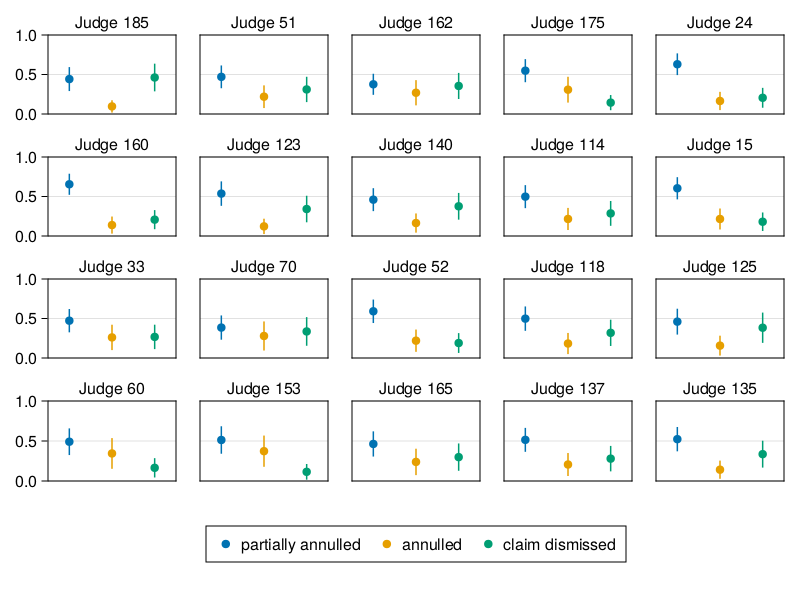

In [39]:
judges = topkgroups(problem.js, 20)
plot_marginal_probabilities(problem, post, judges; label="Judge", ncols=5)

# Senate outcomes

In [16]:
using ArraysOfArrays
using Dictionaries, SplitApplyCombine

In [17]:
function count_outcomes(outcomes, groupvar)
    sortkeys(map(group(groupvar, outcomes)) do os
        [count(==(o), os) for o in 1:3]
    end)
end

count_outcomes (generic function with 1 method)

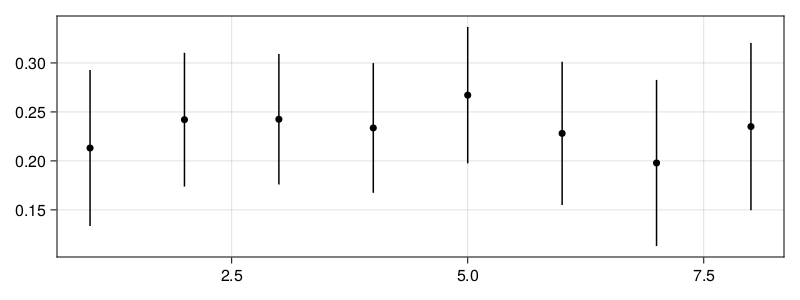

In [18]:
let 
    βs = map(post) do s
        getindex.(map(z -> softmax(vcat(0, s.α .+ z .* s.σs)), s.zs), 3)
    end
    means,sds = mean(βs), std(βs)

    fig = Figure(resolution=(800, 300))
    ax = Axis(fig[1,1])
    errorbars!(ax, eachindex(means), means, 2*sds)
    scatter!(ax, eachindex(means), means; color=:black, markersize=10)
    fig
end

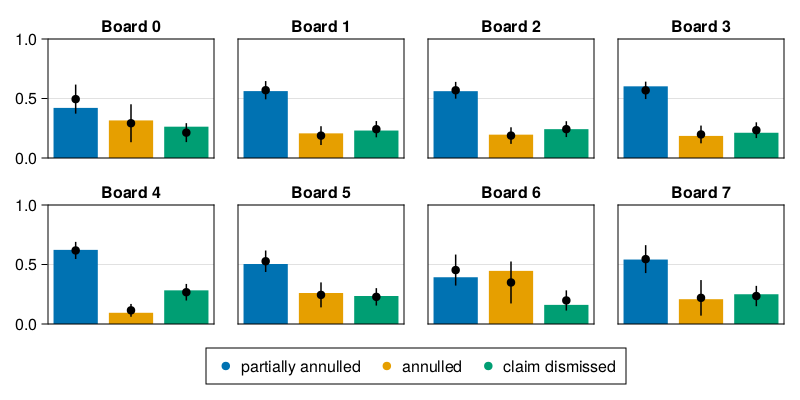

In [76]:
x = let 
    βs = map(post) do s
        map(z -> softmax(vcat(0, s.α .+ z .* s.σs)), s.zs)
    end |> ArrayOfSimilarArrays |> flatview

    means = map(mean, eachrow(βs))
    sds = map(std, eachrow(βs))
    counts = count_outcomes(problem.outcomes, problem.senates)
    
    fig = Figure(resolution=(800, 400))
    colors = Makie.wong_colors()
    
    for i in eachindex(means)
        pos = fldmod1(i, 4)
        ax = Axis(fig[pos...]; title="Board $(i-1)")
        barplot!(ax, 1:3, counts[i] ./ sum(counts[i]); color=colors[1:3])
        errorbars!(ax, 1:3, means[i], 2*sds[i]; color=:black)
        scatter!(ax, 1:3, means[i]; color=:black)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3, tellheight=true)
    
    fig
end

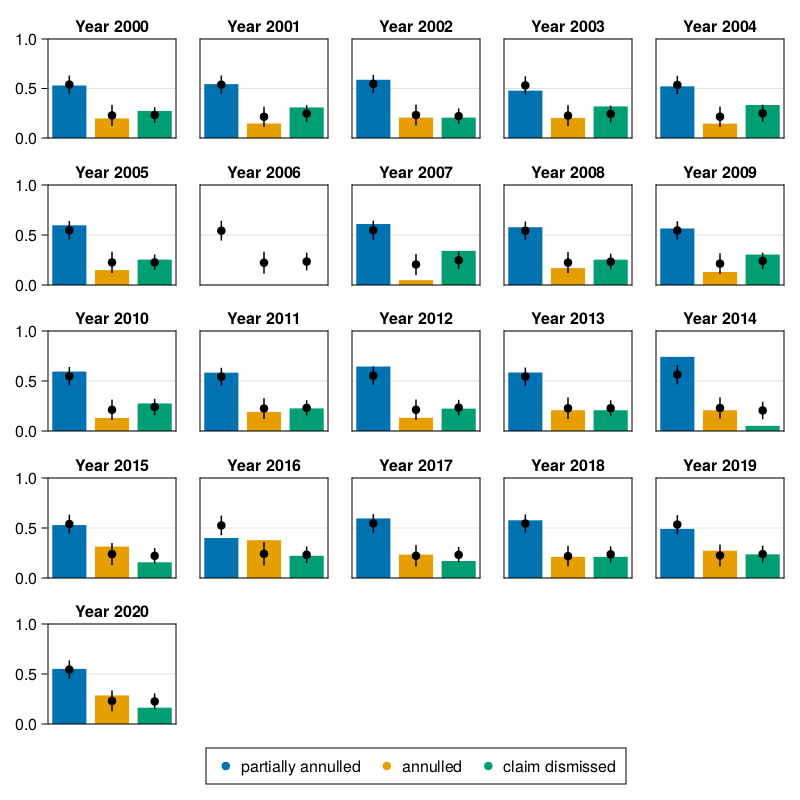

In [20]:
x = let 
    βs = map(post) do s
        map(z -> softmax(vcat(0, s.α .+ z .* s.σy)), s.zy)
    end |> ArrayOfSimilarArrays |> flatview

    means = map(mean, eachrow(βs))
    sds = map(std, eachrow(βs))
    counts = count_outcomes(problem.outcomes, problem.years)
    insert!(counts, 7, [0,0,0])
    sortkeys!(counts)
    
    fig = Figure(resolution=(800, 800))
    colors = Makie.wong_colors()
    
    for i in eachindex(means)
        pos = fldmod1(i, 5)
        ax = Axis(fig[pos...]; title="Year $(2000 - 1 + i)")
        barplot!(ax, 1:3, counts[i] ./ sum(counts[i]); color=colors[1:3])
        errorbars!(ax, 1:3, means[i], 2*sds[i]; color=:black)
        scatter!(ax, 1:3, means[i]; color=:black)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3, tellheight=true)
    
    fig
end

# Variance components

In [77]:
function plot_sds(problem, post)
    fig = Figure(resolution=(800,500))
    colors = Makie.wong_colors()

    plotsigma!(ax, draws) = begin
        density!(first.(draws); color=(colors[2], 0.7))
        density!(last.(draws); color=(colors[3], 0.7))
    end

    ax1 = Axis(fig[1,1]; titlealign=:left, title = "Board varying effect s.d.")
    plotsigma!(ax1, post.σs)
    ax2 = Axis(fig[1,2]; titlealign=:left, title = "Year varying effect s.d.")
    plotsigma!(ax2, post.σy)
    ax3 = Axis(fig[2,1]; titlealign=:left, title = "Judge varying effect s.d.")
    plotsigma!(ax3, post.σj)
    ax4 = Axis(fig[2,2]; titlealign=:left, title = "Technology varying effect s.d.")
    plotsigma!(ax4, post.σt)

    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 2:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels[2:3]; nbanks=2, tellheight=true)
    

    fig
end

plot_sds (generic function with 1 method)

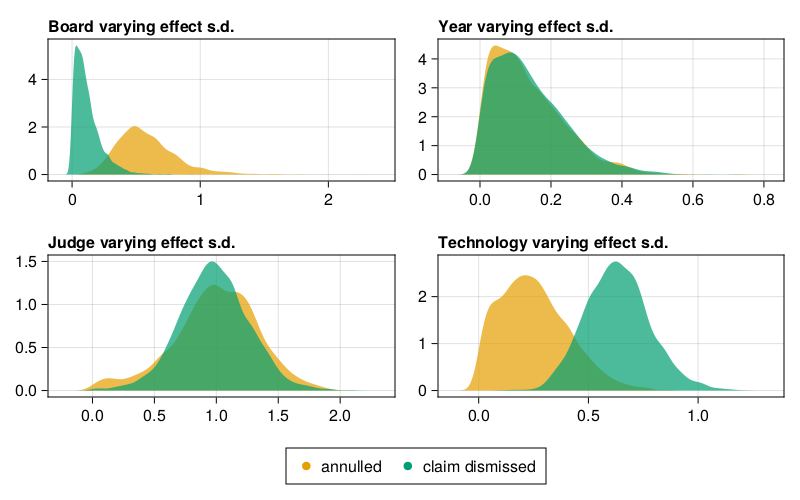

In [78]:
plot_sds(problem, post)

# Model accuracy

In [72]:
using Distributions

function predict(problem, θ)
    (; 
        outcomes, outcome_labels, 
        js, n_js, N_js, 
        cpcs, n_cpcs, N_cpcs,
        senates, N_senates,
        years, N_years,
    ) = problem

    (; α, zs, σs, zy, σy, zj, σj, zt, σt, ) = θ

    map(zip(outcomes, senates, years, js, n_js, cpcs, n_cpcs)) do (oi, si, yi, ji, nji, ti, nti)
        η = α + zs[si] .* σs + zy[yi] .* σy + 
            sum(zj[j] .* σj for j in ji) ./ nji +
            sum(zt[t] .* σt for t in ti) ./ nti
            
        #Categorical(softmax(vcat(0.0, η))) |> rand
        findmax(softmax(vcat(0.0, η)))[2]
    end
end

predict (generic function with 1 method)

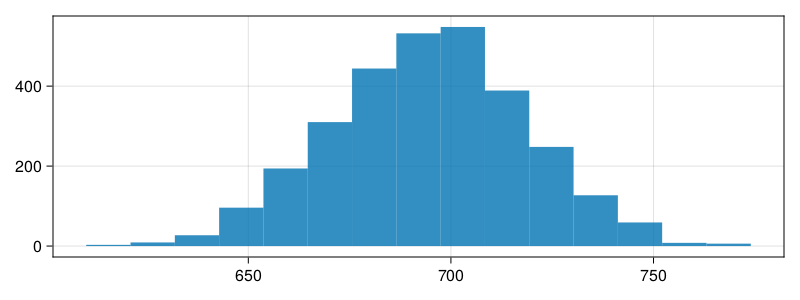

In [65]:
pred_partial = [count(==(1), predict(problem, θ)) for θ in post]
hist(pred_partial; figure=(;resolution=(800, 300)))

In [60]:
function accuracy(problem, θ)
    mean(predict(problem, θ) .== problem.outcomes)
end

accuracy (generic function with 1 method)

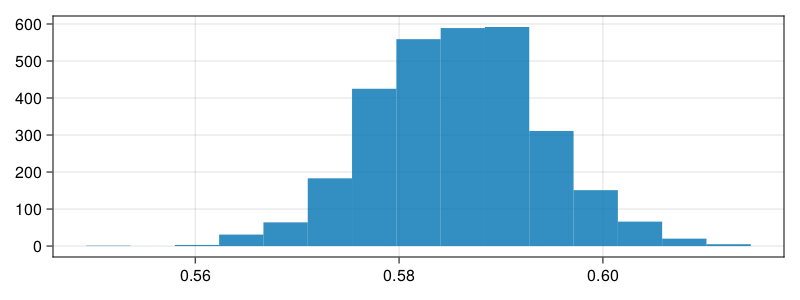

In [73]:
acc = [accuracy(problem, θ) for θ in post]
hist(acc; figure=(;resolution=(800, 300)))